In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import numpy_financial as npf
import matplotlib.pyplot as plt


## DCA Returns and Risk of ETFs 

The below is a practice of calculating Dollar-Cost Averaging Returns and Risk of each ETF. (could be stock but I can only trade ETFs)
I wanted to analyze whether:
1) Dollar-Cost Averaging is actually effective
2) What each ETF can return and comparison of risk/return with other ETFs that I was looking at 


Futher project ideas include:
1) What is the utlimate mix of weights of given portfolio (lowest risk, highest return) 
2) Whether Portoflio composition based on Historical Data promise a return
3) Whether specific day of the month would give higher IRR (that is significant enough to impact the decision)
    - reasoning behind the test would be some belief that "at the end of the month, it always go up!" kinda deal
    
    
Other questions include:
1) Is STD a good way to test volatility? What are other ways of testing RISK for investors?


Inputs Below

In [2]:
start_yr = 2000
start_mo = 1
start_day = 1
initial_start_date = f"{start_yr}-{start_mo}-{start_day}"
# Get today's date
end_date = datetime.today().strftime('%Y-%m-%d')

Functions Below

In [3]:
# Function to get the earliest available date for the ETF // since inception may be much later than the input start_date
def get_earliest_date(etf):
    ticker = yf.Ticker(etf)
    history = ticker.history(period="max")
    if not history.empty:
        return history.index.min()
    else:
        raise ValueError(f"No historical data found for {etf}")

# FUnction to get business day value since historical trade data won't have Saturday, Sunday value
def get_previous_business_day(date, data):
    """Find the nearest previous business day in the data."""
    while date not in data.index:
        date -= timedelta(days=1)
        if date.weekday() == 5:  # Saturday
            date -= timedelta(days=1)
        elif date.weekday() == 6:  # Sunday
            date -= timedelta(days=2)
        if date < data.index.min():
            raise ValueError(f"No valid business days found for {date}")
    return date

Graph it

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


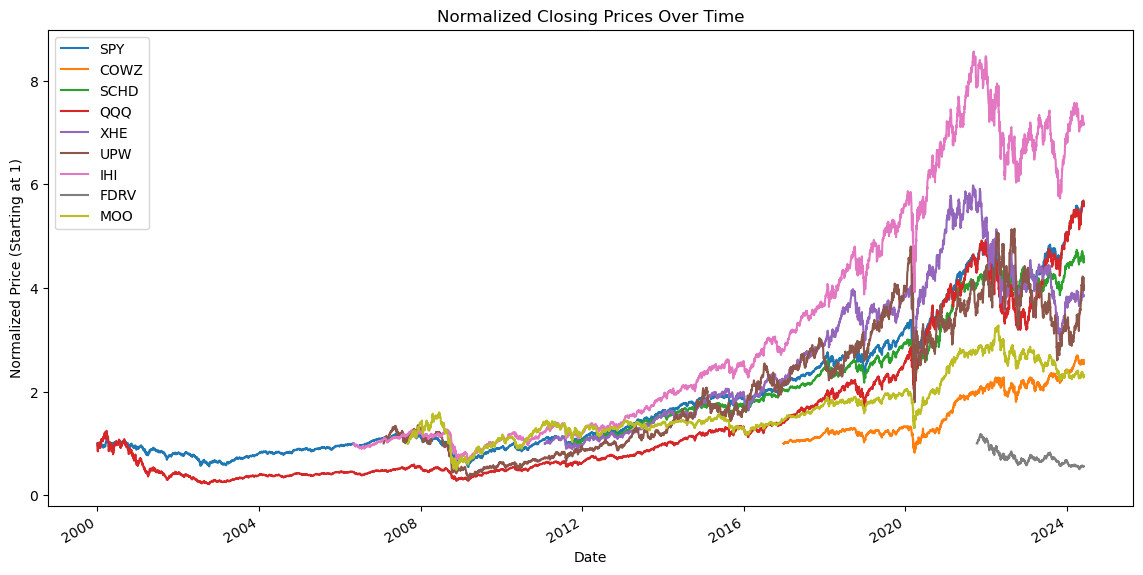

In [4]:
# Define a list of ETF symbols
etf_symbols = ['SPY','COWZ','SCHD','QQQ','XHE','UPW','IHI','FDRV','MOO']

# Risk-free rate (guessed annualized yield of 3 mo T-bill) // prob diff number given today's rate - 2024.06.01
risk_free_rate = 0.025

# Fetch adjusted close prices for each ETF / thanks yahoo finance
etf_data = {}
for etf in etf_symbols:
    etf_data[etf] = yf.download(etf, start=initial_start_date, end=end_date)['Adj Close']

# Normalize the prices 
normalized_prices = pd.DataFrame()
for etf in etf_symbols:
    normalized_prices[etf] = etf_data[etf] / etf_data[etf].iloc[0]

# Plot the normalized prices over time
plt.figure(figsize=(14, 7))
for etf in etf_symbols:
    normalized_prices[etf].plot(label=etf)

plt.title('Normalized Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Price (Starting at 1)')
plt.legend()
plt.show()

ETF: SPY
Annualized volatility of SPY is  17.99%
Annualized IRR of SPY is  10.81%
ETF: COWZ
Annualized volatility of COWZ is  19.31%
Annualized IRR of COWZ is  15.04%
ETF: SCHD
Annualized volatility of SCHD is  15.02%
Annualized IRR of SCHD is  11.61%
ETF: QQQ
Annualized volatility of QQQ is  24.13%
Annualized IRR of QQQ is  14.80%
ETF: XHE
Annualized volatility of XHE is  27.14%
Annualized IRR of XHE is  8.04%
ETF: UPW
Annualized volatility of UPW is  37.07%
Annualized IRR of UPW is  11.88%
ETF: IHI
Annualized volatility of IHI is  20.55%
Annualized IRR of IHI is  13.00%
ETF: FDRV
Annualized volatility of FDRV is  34.22%
Annualized IRR of FDRV is -16.49%
ETF: MOO
Annualized volatility of MOO is  18.59%
Annualized IRR of MOO is  5.07%


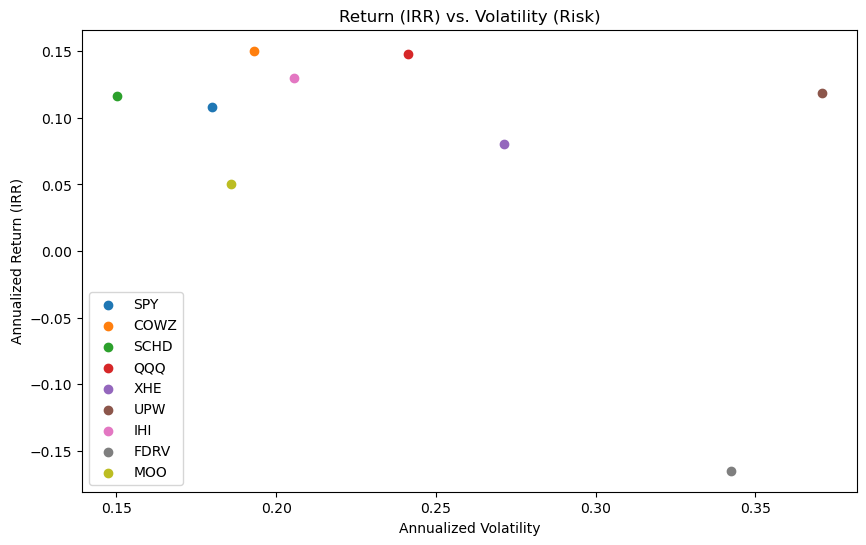

In [5]:
# Calculate daily returns for ETFs
etf_returns = pd.DataFrame()
for etf in etf_symbols:
    etf_returns[etf] = etf_data[etf].pct_change()

# Remove NaN values
etf_returns.dropna(inplace=True)

# Calculate daily and annualized volatility (standard deviation) for each ETF
daily_volatility = etf_returns.std()
annualized_volatility = daily_volatility * np.sqrt(252)

# Define the initial investment amount and annual increase rate
initial_investment_amount = 1000
annual_increase_rate = 0.02

def calculate_irr_with_dca(etf):
    # Generate all monthly dates from start date until today
    # Get the inception date
    inception_date = get_earliest_date(etf)
    inception_date = inception_date.tz_localize(None)  # Ensure timezone-naive - okay, this actually not sure but got some help from internet
    start_date = max(pd.to_datetime(initial_start_date), inception_date)
        
    # monthly investment dates
    investment_dates = pd.date_range(start=start_date, end=end_date, freq='M')
    returns = etf_returns[etf]

    # calculate DCA investments with annual increase
    investments = []
    total_shares = 0
    current_investment_amount = initial_investment_amount
    for i, date in enumerate(investment_dates):
        
        try:
            date = get_previous_business_day(date, etf_data[etf])
            close_price = etf_data[etf].loc[date]
            shares = current_investment_amount / close_price
            total_shares += shares
            investments.append((date, shares, current_investment_amount))

            # Increase the investment amount every 12 months (yearly)
            if (i + 1) % 12 == 0:
                current_investment_amount *= (1 + annual_increase_rate)

        except ValueError as e:
            print(f"Skipping date {date}: {e}")

    # calculate the final value of the DCA investment
    final_value_dca = total_shares * etf_data[etf].loc[investment_dates[-1]]

    # create cash flows list for IRR calculation of DCA
    dca_cash_flows = [-initial_investment_amount * (1 + annual_increase_rate) ** (i // 12) for i in range(len(investment_dates))] + [final_value_dca]
    
    # Calculate IRR for DCA
    irr_monthly = npf.irr(dca_cash_flows)
    irr_annual = (1 + irr_monthly) ** 12 - 1
    return irr_annual

# Calculate IRR and store values for plotting
annual_returns = {etf: calculate_irr_with_dca(etf) for etf in etf_symbols}

# Plot the return (IRR) against volatility (risk)
plt.figure(figsize=(10, 6))
for etf in etf_symbols:
    plt.scatter(annualized_volatility[etf], annual_returns[etf], label=etf)
    print(f"ETF: {etf}")
    print(f"Annualized volatility of {etf} is {annualized_volatility[etf]: .2%}")
    print(f"Annualized IRR of {etf} is {annual_returns[etf]: .2%}")

plt.title('Return (IRR) vs. Volatility (Risk)')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return (IRR)')
plt.legend()
plt.show()


Other Practices

In [6]:
# Create a dictionary to store the data
etf_data_dict = {}

# Loop through the list of ETF symbols and fetch data
for etf in etf_symbols:
    # fetch historical data
    etf_data = yf.download(etf, start=initial_start_date, end=end_date)
    
    # Store the data in the dictionary
    etf_data_dict[etf] = etf_data

    # print the first few rows of the fetched data
    print(f"Historical data for {etf}:")
    print(etf_data.head())
    print("\n")

    # save the data to a CSV file
    # etf_data.to_csv(f"{etf}_historical_data.csv")

# Example of using NumPy for further analysis
for etf, data in etf_data_dict.items():
    # Convert the 'Adj Close' column to Numpy
    adj_close_np = data['Adj Close'].values

    # Calculate the daily returns using NumPy
    daily_returns = np.diff(adj_close_np) / adj_close_np[:-1]
    
    # Add the daily returns as a new column in the DataFrame
    etf_data_dict[etf]['Daily Returns'] = np.append([np.nan], daily_returns)  # Add NaN for the first row

    # Optionally, print the first few rows of the updated data
    print(f"Data with daily returns for {etf}:")
    print(etf_data_dict[etf].head())
    print("\n")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Historical data for SPY:
                 Open       High         Low     Close  Adj Close    Volume
Date                                                                       
2000-01-03  148.25000  148.25000  143.875000  145.4375  93.591164   8164300
2000-01-04  143.53125  144.06250  139.640625  139.7500  89.931152   8089800
2000-01-05  139.93750  141.53125  137.250000  140.0000  90.092041  12177900
2000-01-06  139.62500  141.50000  137.750000  137.7500  88.644135   6227200
2000-01-07  140.31250  145.75000  140.062500  145.7500  93.792252   8066500


Historical data for COWZ:
                 Open   High        Low      Close  Adj Close  Volume
Date                                                                 
2016-12-22  24.969999  24.98  24.780001  24.799999  21.551973   56800
2016-12-23  24.900000  24.90  24.809999  24.850000  21.595432   19500
2016-12-27  24.930000  25.02  24.930000  24.959999  21.691019   16600
2016-12-28  24.959999  24.98  24.670000  24.690001  21.484791   1

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Historical data for UPW:
                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2007-02-01  23.566668  23.566668  23.566668  23.566668  16.143757    1800
2007-02-02  23.930000  24.013332  23.930000  24.013332  16.449724     600
2007-02-05  24.110001  24.110001  24.110001  24.110001  16.515959     300
2007-02-06  24.110001  24.110001  24.110001  24.110001  16.515959       0
2007-02-07  24.953333  24.953333  24.913334  24.913334  17.066256    2400


Historical data for IHI:
                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2006-05-05  8.210000  8.280000  8.210000  8.280000   7.743153  300600
2006-05-08  8.270000  8.281667  8.246667  8.273333   7.736919   14400
2006-05-09  8.260000  8.273333  8.235000  8.235000   7.701071   53400
2006-05-10  8.233333  8.258333  8.201667  8.201667   7.669899   90000
2006-05-11